# Data Processing:

In [ ]:
# Mount into drive

# from google.colab import drive

# drive.mount("/content/drive")

# %cd '/content/drive/MyDrive/Colab Notebooks/Money Printer/'

# !pip install -r requirements.txt
!pip install pandas
!pip install -U scikit-learn
!pip install torchinfo


In [1]:
# import data_loader
import pandas as pd
from pathlib import Path
import numpy as np
from torch.utils import data
import torch

In [2]:
train_data_all = pd.read_csv('Train_NoAuction_Zscore.csv')
test_data = pd.read_csv('Test_NoAuction_Zscore.csv')

In [3]:

#Split train data to train and validation sets:
train_data = train_data_all.iloc[:int(np.floor(train_data_all.shape[0]*0.8)), :]
val_data = train_data_all.iloc[int(np.floor(train_data_all.shape[0]*0.8)):, :]

In [4]:
def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [5]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization"""
        self.k = k
        self.num_classes = num_classes
        self.T = T

        x = data.iloc[:,:40]
        y = data.iloc[:,-5:]
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [6]:
batch_size = 64

# dataset_train = Dataset(data=train_data, k=4, num_classes=3, T=100)
# dataset_val = Dataset(data=val_data, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=test_data, k=4, num_classes=3, T=100)

# train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

# print(dataset_train.x.shape, dataset_train.y.shape)

# Model Architecture:

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class DeepLOB(nn.Module):
    def __init__(self, n_classes=3):
        super(DeepLOB, self).__init__()

        self.n_classes = n_classes
        # self.device = device
        # 1. Convolutional layers
        ## 1st convolution:

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # 2. Inception Layer:
        ##1st inc 1x1 3x1
        self.inc1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inception_num+=1

        ##2nd inc 1x1 5x1
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inception_num+=1

        ##3nd inc max_pool 1x1
        self.inc3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inception_num+=1

        # 2. LSTM layers

        self.lstm_in_size = self.inception_num*64
        self.lstm = nn.LSTM(192, hidden_size=64, num_layers=1,batch_first=True)
        self.fc1 = nn.Linear(64, self.n_classes)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        inception1 = self.inc1(x)
        inception2 = self.inc2(x)
        inception3 = self.inc3(x)

        x = torch.cat((inception1, inception2, inception3), dim=1)

        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))

        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        output = torch.softmax(x, dim=1)

        return output

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DeepLOB(n_classes = 3)
model.to(device)

DeepLOB(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [10]:
from torchinfo import summary
summary(model, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
DeepLOB                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

# Training

In [11]:
from tqdm import tqdm
from datetime import datetime
from sklearn.metrics import accuracy_score, classification_report

In [12]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):

        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        if test_loss < best_test_loss:
            torch.save(model, 'best_val_model_pytorch_k4.pt')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = batch_gd(model, criterion, optimizer,
                                    train_loader, val_loader, epochs=50)

  2%|▏         | 1/50 [02:53<2:21:52, 173.72s/it]

model saved
Epoch 1/50, Train Loss: 0.9234,           Validation Loss: 0.8949, Duration: 0:02:53.722227, Best Val Epoch: 0


  4%|▍         | 2/50 [05:47<2:19:12, 174.01s/it]

Epoch 2/50, Train Loss: 0.8383,           Validation Loss: 0.9001, Duration: 0:02:54.207374, Best Val Epoch: 0


  6%|▌         | 3/50 [08:43<2:16:53, 174.76s/it]

model saved
Epoch 3/50, Train Loss: 0.8106,           Validation Loss: 0.8561, Duration: 0:02:55.659128, Best Val Epoch: 2


  8%|▊         | 4/50 [11:37<2:13:39, 174.33s/it]

model saved
Epoch 4/50, Train Loss: 0.7927,           Validation Loss: 0.8538, Duration: 0:02:53.666316, Best Val Epoch: 3


 10%|█         | 5/50 [14:31<2:10:40, 174.24s/it]

model saved
Epoch 5/50, Train Loss: 0.7791,           Validation Loss: 0.8449, Duration: 0:02:54.069227, Best Val Epoch: 4


 12%|█▏        | 6/50 [17:25<2:07:44, 174.19s/it]

Epoch 6/50, Train Loss: 0.7688,           Validation Loss: 0.8463, Duration: 0:02:54.085189, Best Val Epoch: 4


 14%|█▍        | 7/50 [20:19<2:04:51, 174.22s/it]

model saved
Epoch 7/50, Train Loss: 0.7586,           Validation Loss: 0.8419, Duration: 0:02:54.295027, Best Val Epoch: 6


 16%|█▌        | 8/50 [23:13<2:01:48, 174.00s/it]

model saved
Epoch 8/50, Train Loss: 0.7510,           Validation Loss: 0.8325, Duration: 0:02:53.530025, Best Val Epoch: 7


 18%|█▊        | 9/50 [26:07<1:58:54, 174.01s/it]

Epoch 9/50, Train Loss: 0.7439,           Validation Loss: 0.8419, Duration: 0:02:54.017497, Best Val Epoch: 7


 20%|██        | 10/50 [29:01<1:56:02, 174.07s/it]

Epoch 10/50, Train Loss: 0.7377,           Validation Loss: 0.8410, Duration: 0:02:54.207761, Best Val Epoch: 7


 22%|██▏       | 11/50 [30:28<1:35:53, 147.52s/it]

Epoch 11/50, Train Loss: 0.7322,           Validation Loss: 0.8494, Duration: 0:01:27.304257, Best Val Epoch: 7


 24%|██▍       | 12/50 [32:15<1:25:34, 135.12s/it]

Epoch 12/50, Train Loss: 0.7264,           Validation Loss: 0.8423, Duration: 0:01:46.752515, Best Val Epoch: 7


 26%|██▌       | 13/50 [33:51<1:15:57, 123.17s/it]

Epoch 13/50, Train Loss: 0.7223,           Validation Loss: 0.8369, Duration: 0:01:35.666344, Best Val Epoch: 7


 28%|██▊       | 14/50 [36:05<1:15:57, 126.60s/it]

Epoch 14/50, Train Loss: 0.7187,           Validation Loss: 0.8437, Duration: 0:02:14.526528, Best Val Epoch: 7


 30%|███       | 15/50 [38:59<1:22:06, 140.76s/it]

Epoch 15/50, Train Loss: 0.7145,           Validation Loss: 0.8397, Duration: 0:02:53.566263, Best Val Epoch: 7


 32%|███▏      | 16/50 [41:54<1:25:34, 151.00s/it]

Epoch 16/50, Train Loss: 0.7110,           Validation Loss: 0.8360, Duration: 0:02:54.793332, Best Val Epoch: 7


 34%|███▍      | 17/50 [44:47<1:26:49, 157.88s/it]

Epoch 17/50, Train Loss: 0.7075,           Validation Loss: 0.8365, Duration: 0:02:53.858472, Best Val Epoch: 7


 36%|███▌      | 18/50 [47:41<1:26:47, 162.73s/it]

Epoch 18/50, Train Loss: 0.7046,           Validation Loss: 0.8408, Duration: 0:02:54.026524, Best Val Epoch: 7


 38%|███▊      | 19/50 [50:37<1:26:07, 166.69s/it]

Epoch 19/50, Train Loss: 0.7023,           Validation Loss: 0.8512, Duration: 0:02:55.920873, Best Val Epoch: 7


 40%|████      | 20/50 [53:32<1:24:28, 168.94s/it]

Epoch 20/50, Train Loss: 0.7000,           Validation Loss: 0.8392, Duration: 0:02:54.158586, Best Val Epoch: 7


 42%|████▏     | 21/50 [56:26<1:22:24, 170.51s/it]

Epoch 21/50, Train Loss: 0.6974,           Validation Loss: 0.8431, Duration: 0:02:54.167606, Best Val Epoch: 7


 44%|████▍     | 22/50 [59:19<1:19:58, 171.39s/it]

Epoch 22/50, Train Loss: 0.6959,           Validation Loss: 0.8408, Duration: 0:02:53.443521, Best Val Epoch: 7


 46%|████▌     | 23/50 [1:02:13<1:17:24, 172.01s/it]

Epoch 23/50, Train Loss: 0.6938,           Validation Loss: 0.8435, Duration: 0:02:53.474374, Best Val Epoch: 7


 48%|████▊     | 24/50 [1:05:06<1:14:43, 172.45s/it]

Epoch 24/50, Train Loss: 0.6913,           Validation Loss: 0.8397, Duration: 0:02:53.475507, Best Val Epoch: 7


 50%|█████     | 25/50 [1:07:59<1:11:57, 172.71s/it]

Epoch 25/50, Train Loss: 0.6895,           Validation Loss: 0.8411, Duration: 0:02:53.298815, Best Val Epoch: 7


 52%|█████▏    | 26/50 [1:10:54<1:09:19, 173.30s/it]

Epoch 26/50, Train Loss: 0.6879,           Validation Loss: 0.8386, Duration: 0:02:54.692974, Best Val Epoch: 7


 54%|█████▍    | 27/50 [1:13:50<1:06:40, 173.95s/it]

Epoch 27/50, Train Loss: 0.6855,           Validation Loss: 0.8423, Duration: 0:02:55.456906, Best Val Epoch: 7


 56%|█████▌    | 28/50 [1:16:43<1:03:43, 173.78s/it]

Epoch 28/50, Train Loss: 0.6846,           Validation Loss: 0.8437, Duration: 0:02:53.393845, Best Val Epoch: 7


 58%|█████▊    | 29/50 [1:19:36<1:00:47, 173.67s/it]

Epoch 29/50, Train Loss: 0.6828,           Validation Loss: 0.8439, Duration: 0:02:53.410121, Best Val Epoch: 7


 60%|██████    | 30/50 [1:22:30<57:54, 173.74s/it]  

Epoch 30/50, Train Loss: 0.6815,           Validation Loss: 0.8415, Duration: 0:02:53.900026, Best Val Epoch: 7


 62%|██████▏   | 31/50 [1:25:24<54:58, 173.61s/it]

Epoch 31/50, Train Loss: 0.6797,           Validation Loss: 0.8419, Duration: 0:02:53.292914, Best Val Epoch: 7


 64%|██████▍   | 32/50 [1:28:17<52:05, 173.65s/it]

Epoch 32/50, Train Loss: 0.6780,           Validation Loss: 0.8416, Duration: 0:02:53.728652, Best Val Epoch: 7


 66%|██████▌   | 33/50 [1:31:11<49:10, 173.53s/it]

Epoch 33/50, Train Loss: 0.6776,           Validation Loss: 0.8426, Duration: 0:02:53.264476, Best Val Epoch: 7


 68%|██████▊   | 34/50 [1:34:06<46:26, 174.18s/it]

Epoch 34/50, Train Loss: 0.6753,           Validation Loss: 0.8498, Duration: 0:02:55.694126, Best Val Epoch: 7


 70%|███████   | 35/50 [1:37:01<43:34, 174.30s/it]

Epoch 35/50, Train Loss: 0.6747,           Validation Loss: 0.8455, Duration: 0:02:54.586883, Best Val Epoch: 7


 72%|███████▏  | 36/50 [1:39:55<40:39, 174.23s/it]

Epoch 36/50, Train Loss: 0.6735,           Validation Loss: 0.8428, Duration: 0:02:54.070187, Best Val Epoch: 7


 74%|███████▍  | 37/50 [1:42:49<37:44, 174.21s/it]

Epoch 37/50, Train Loss: 0.6720,           Validation Loss: 0.8427, Duration: 0:02:54.163443, Best Val Epoch: 7


 76%|███████▌  | 38/50 [1:45:43<34:49, 174.12s/it]

Epoch 38/50, Train Loss: 0.6709,           Validation Loss: 0.8476, Duration: 0:02:53.911013, Best Val Epoch: 7


 78%|███████▊  | 39/50 [1:48:37<31:56, 174.19s/it]

Epoch 39/50, Train Loss: 0.6699,           Validation Loss: 0.8437, Duration: 0:02:54.340452, Best Val Epoch: 7


 80%|████████  | 40/50 [1:51:31<29:00, 174.04s/it]

Epoch 40/50, Train Loss: 0.6695,           Validation Loss: 0.8485, Duration: 0:02:53.683936, Best Val Epoch: 7


 82%|████████▏ | 41/50 [1:54:25<26:06, 174.01s/it]

Epoch 41/50, Train Loss: 0.6677,           Validation Loss: 0.8451, Duration: 0:02:53.952327, Best Val Epoch: 7


 84%|████████▍ | 42/50 [1:57:20<23:13, 174.22s/it]

Epoch 42/50, Train Loss: 0.6671,           Validation Loss: 0.8476, Duration: 0:02:54.715253, Best Val Epoch: 7


 86%|████████▌ | 43/50 [2:00:15<20:22, 174.65s/it]

Epoch 43/50, Train Loss: 0.6667,           Validation Loss: 0.8445, Duration: 0:02:55.650053, Best Val Epoch: 7


 88%|████████▊ | 44/50 [2:03:09<17:26, 174.42s/it]

Epoch 44/50, Train Loss: 0.6649,           Validation Loss: 0.8519, Duration: 0:02:53.883563, Best Val Epoch: 7


 90%|█████████ | 45/50 [2:06:04<14:31, 174.38s/it]

Epoch 45/50, Train Loss: 0.6639,           Validation Loss: 0.8455, Duration: 0:02:54.291570, Best Val Epoch: 7


 92%|█████████▏| 46/50 [2:08:58<11:37, 174.33s/it]

Epoch 46/50, Train Loss: 0.6647,           Validation Loss: 0.8427, Duration: 0:02:54.197383, Best Val Epoch: 7


 94%|█████████▍| 47/50 [2:11:52<08:42, 174.21s/it]

Epoch 47/50, Train Loss: 0.6633,           Validation Loss: 0.8438, Duration: 0:02:53.940769, Best Val Epoch: 7


 96%|█████████▌| 48/50 [2:14:46<05:48, 174.26s/it]

Epoch 48/50, Train Loss: 0.6626,           Validation Loss: 0.8488, Duration: 0:02:54.355534, Best Val Epoch: 7


 98%|█████████▊| 49/50 [2:17:40<02:54, 174.11s/it]

Epoch 49/50, Train Loss: 0.6614,           Validation Loss: 0.8498, Duration: 0:02:53.779471, Best Val Epoch: 7


100%|██████████| 50/50 [2:20:34<00:00, 168.69s/it]

Epoch 50/50, Train Loss: 0.6602,           Validation Loss: 0.8425, Duration: 0:02:54.244552, Best Val Epoch: 7


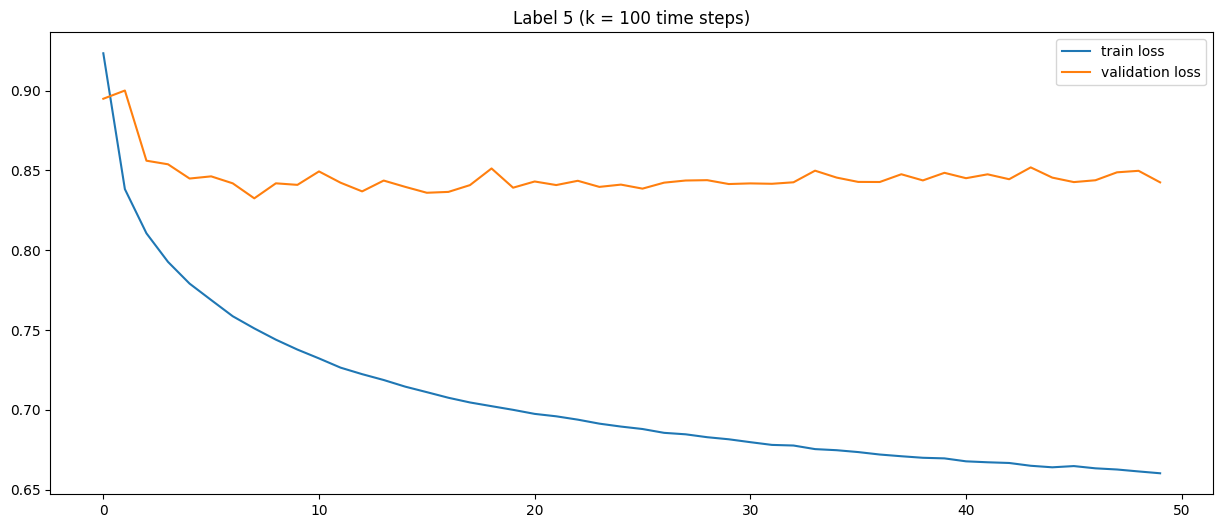

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.title('Label 5 (k = 100 time steps)')
plt.legend()

# **Testing Model**

In [ ]:
# test_loader = torch.utils.data.DataLoader('/content/drive/MyDrive/Colab Notebooks/Money Printer/test_loader.pth')

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
from sklearn.metrics import accuracy_score, classification_report
model = torch.load('best_val_model_pytorch_k4.pt')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

<ipython-input-12-355a49afe3d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_val_model_pytorch_k4.pt')


Test acc: 0.7298


In [13]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)
all_predictions = np.concatenate(all_predictions)

print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.7297545308557009
              precision    recall  f1-score   support

           0     0.7021    0.7065    0.7043     47915
           1     0.8087    0.7647    0.7861     48050
           2     0.6806    0.7167    0.6982     43523

    accuracy                         0.7298    139488
   macro avg     0.7305    0.7293    0.7295    139488
weighted avg     0.7321    0.7298    0.7306    139488

